<a href="https://colab.research.google.com/github/arvindsuresh-math/Aug-2025-Math-Solution-Classifier/blob/main/notebooks/modeling_oct_17_additive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 1: Additive Model for Price-Per-Person (Baseline)

## 1. Objective

The goal of this notebook is to establish a performance baseline for predicting the `price_per_person` of an Airbnb listing. This experiment uses a purely additive, multi-axis neural network, which is designed for high explainability.

## 2. Methodology

*   **Model Architecture:** An additive neural network with 6 parallel sub-networks, one for each of the following feature axes:
    1.  Location
    2.  Size & Capacity
    3.  Quality & Reputation
    4.  Amenities (Text)
    5.  Description (Text)
    6.  Seasonality
*   **Target Variable:** `price_per_person` (untransformed, in dollars).
*   **Loss Function:** Root Mean Squared Error (RMSE), which optimizes for direct dollar-space error. This model does not use sample weighting.

## 3. Key Features

*   **Modular Code:** The notebook is structured with distinct classes for configuration, feature processing, data loading, and modeling to ensure clarity and reusability.
*   **End-to-End Pipeline:** A single `main()` function orchestrates the entire workflow from data loading to model training and artifact saving.
*   **Robust Training:** The training loop includes early stopping to prevent overfitting and saves the best model based on validation performance.
*   **Performance Analysis:** After training, the model's performance is evaluated by calculating the Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) across different price-per-person brackets.

## 4. Expected Outcome

This notebook will produce a trained model artifact (`.pt` file) and a detailed performance report. This baseline will serve as the benchmark against which more complex models (e.g., those using log-transformed targets) will be compared.

#### **0. Setup and Installations**

In [1]:
# --- Hugging Face Authentication (using Colab Secrets) ---
from google.colab import userdata
from huggingface_hub import login
print("Attempting Hugging Face login...")
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print("Hugging Face login successful.")
except Exception as e:
    print(f"Could not log in. Please ensure 'HF_TOKEN' is a valid secret. Error: {e}")

Attempting Hugging Face login...
Hugging Face login successful.


In [2]:
# --- Mount Google Drive ---
from google.colab import drive
print("Mounting Google Drive...")
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Could not mount Google Drive. Error: {e}")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [3]:
# --- Install Dependencies ---
!pip install pandas
!pip install pyarrow
!pip install sentence-transformers
!pip install scikit-learn
!pip install torch
!pip install tqdm

### **1. Configuration and Helper Functions**

This section contains all hyperparameters in a `Config` class for easy management, along with the `set_seed` utility function for ensuring reproducible results. The key new parameter is `PRICE_BUCKET_SIZE`.

In [4]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# --- Seeding function for reproducibility ---
def set_seed(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"All random seeds set to {seed}.")

class Config:
    # --- Data and Environment ---
    CITY: str = "nyc"
    DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
    DRIVE_SAVE_PATH: str = "/content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/"
    TEXT_MODEL_NAME: str = 'BAAI/bge-small-en-v1.5' # 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'

    # --- Data Pre-processing ---
    VAL_SIZE: float = 0.2

    # --- Reproducibility ---
    SEED: int = 42

    # --- Model Training ---
    BATCH_SIZE: int = 4096
    LEARNING_RATE: float = 1e-3
    N_EPOCHS: int = 30

    # --- Early Stopping ---
    EARLY_STOPPING_PATIENCE: int = 5
    EARLY_STOPPING_MIN_DELTA: float = 0.1 # Min improvement in RW-MSE ($) to reset patience is 10 cents

    # --- Logging ---
    LOG_EVERY_N_STEPS: int = 10

### **2. Data Loading and Splitting**

In [6]:
def load_and_split_data(config: Config):
    """
    Loads data, removes price outliers, and performs a 3-way stratified split.
    """
    dataset_filename = f"{config.CITY}_dataset_oct_17.parquet" # Assumes this file matches the new schema
    dataset_path = f"./{dataset_filename}"

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"'{dataset_filename}' not found. Please upload the file.")

    print(f"Loading dataset from: {dataset_path}")
    df = pd.read_parquet(dataset_path)

    # Create bins for stratifying continuous price_per_person
    df['price_bin'] = pd.qcut(df['price_per_person'], q=10, labels=False)

    stratify_key = (
        df['neighbourhood_cleansed'].astype(str) + '_' +
        df['month'].astype(str) + '_' +
        df['price_bin'].astype(str)
    )

    strata_counts = stratify_key.value_counts()
    valid_strata = strata_counts[strata_counts >= 2].index
    df_filtered = df[stratify_key.isin(valid_strata)].copy()
    print(f"Removed small strata. New size: {len(df_filtered):,} records.")

    train_indices, val_indices = train_test_split(
        df_filtered.index,
        test_size=config.VAL_SIZE,
        random_state=config.SEED,
        stratify=stratify_key[df_filtered.index]
    )

    train_df = df_filtered.loc[train_indices].reset_index(drop=True)
    val_df = df_filtered.loc[val_indices].reset_index(drop=True)

    print(f"Split complete. Training: {len(train_df):,}, Validation: {len(val_df):,}")
    return train_df, val_df

### **3. Feature Processor**

In [7]:
class FeatureProcessor:
    def __init__(self, embedding_dim_geo: int = 32):
        self.vocabs, self.scalers = {}, {}
        self.embedding_dim_geo = embedding_dim_geo
        # --- UPDATED feature categories ---
        self.categorical_cols = ["neighbourhood_cleansed", "property_type", "room_type"]
        self.numerical_cols = [
            "accommodates", "review_scores_rating", "review_scores_cleanliness",
            "review_scores_checkin", "review_scores_communication", "review_scores_location",
            "review_scores_value", "bedrooms", "beds", "bathrooms" # Now treated as continuous
        ]
        self.log_transform_cols = ["total_reviews"]
        self.boolean_cols = ["host_is_superhost"]

    def _create_positional_encoding(self, value, max_val):
        d = self.embedding_dim_geo
        pe = np.zeros(d)
        position = (value / max_val) * 10000
        div_term = np.exp(np.arange(0, d, 2) * -(np.log(10000.0) / d))
        pe[0::2] = np.sin(position * div_term)
        pe[1::2] = np.cos(position * div_term)
        return pe

    def fit(self, df: pd.DataFrame):
        print("Fitting FeatureProcessor...")
        for col in self.categorical_cols:
            valid_uniques = df[col].dropna().unique().tolist()
            self.vocabs[col] = {val: i for i, val in enumerate(["<UNK>"] + sorted(valid_uniques))}

        for col in self.numerical_cols + self.log_transform_cols:
            # For numerical columns, convert to numeric coercing errors, then fill NaNs with the mean of the column
            numeric_series = pd.to_numeric(df[col], errors='coerce')
            mean_val = numeric_series.mean()
            filled_series = numeric_series.fillna(mean_val)

            vals = np.log1p(filled_series) if col in self.log_transform_cols else filled_series
            self.scalers[col] = {'mean': vals.mean(), 'std': vals.std() if vals.std() > 0 else 1.0}
        print("Fit complete.")

    def transform(self, df: pd.DataFrame) -> dict:
        df = df.copy()
        # --- Axis 1: Location ---
        half_dim = self.embedding_dim_geo // 2
        lat_enc = np.stack(df['latitude'].apply(lambda x: self._create_positional_encoding(x, 90)[:half_dim]))
        lon_enc = np.stack(df['longitude'].apply(lambda x: self._create_positional_encoding(x, 180)[:half_dim]))
        geo_position = np.hstack([lat_enc, lon_enc])
        neighbourhood = df["neighbourhood_cleansed"].apply(lambda x: self.vocabs["neighbourhood_cleansed"].get(x, 0)).values

        # --- Axis 2: Size & Capacity ---
        size_features = {}
        for col in ["property_type", "room_type"]:
            size_features[col] = df[col].apply(lambda x: self.vocabs[col].get(x, 0)).values
        for col in ["accommodates", "bedrooms", "beds", "bathrooms"]:
            numeric_series = pd.to_numeric(df[col], errors='coerce').fillna(self.scalers[col]['mean'])
            size_features[col] = ((numeric_series - self.scalers[col]['mean']) / self.scalers[col]['std']).values

        # --- Axis 3: Quality & Reputation ---
        quality_features = {}
        for col in self.numerical_cols:
            if col not in ["accommodates", "bedrooms", "beds", "bathrooms"]:
                 numeric_series = pd.to_numeric(df[col], errors='coerce').fillna(self.scalers[col]['mean'])
                 quality_features[col] = ((numeric_series - self.scalers[col]['mean']) / self.scalers[col]['std']).values
        quality_features["total_reviews"] = ((np.log1p(df["total_reviews"]) - self.scalers["total_reviews"]["mean"]) / self.scalers["total_reviews"]["std"]).values
        quality_features["host_is_superhost"] = df["host_is_superhost"].astype(float).values

        # --- Axis 6: Seasonality ---
        month_sin = np.sin(2 * np.pi * df["month"] / 12)
        month_cos = np.cos(2 * np.pi * df["month"] / 12)

        return {
            "location": {"geo_position": geo_position, "neighbourhood": neighbourhood},
            "size_capacity": size_features,
            "quality": quality_features,
            "amenities": {"text": df["amenities"].fillna("").tolist()},
            "description": {"text": df["description"].fillna("").tolist()},
            "seasonality": {"cyclical": np.vstack([month_sin, month_cos]).T},
            "target": df["price_per_person"].values
        }

### **4. AirbnbDataset Class**

The PyTorch `Dataset` class, which defines how to retrieve a single item from our processed feature dictionary.

In [8]:
class AirbnbPriceDataset(Dataset):
    def __init__(self, features: dict):
        self.features = features
        self.n_samples = len(features['target'])

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index: int) -> dict:
        item = {
            'loc_geo_position': self.features['location']['geo_position'][index],
            'loc_neighbourhood': self.features['location']['neighbourhood'][index],
            'amenities_text': self.features['amenities']['text'][index],
            'description_text': self.features['description']['text'][index],
            'season_cyclical': self.features['seasonality']['cyclical'][index],
            'target': self.features['target'][index]
        }
        for k, v in self.features['size_capacity'].items(): item[f'size_{k}'] = v[index]
        for k, v in self.features['quality'].items(): item[f'qual_{k}'] = v[index]
        return item

### **5. Dataloader Creation**

A function to create the `DataLoader` instances, including the custom collate function for batch tokenization.

In [9]:
def preprocess_and_tensorize_CPU(processor, df):
    features_numpy = processor.transform(df)
    features_tensor = {}
    for key, value in features_numpy.items():
        if key in ['amenities', 'description']:
            features_tensor[key] = value
        elif isinstance(value, dict):
            features_tensor[key] = {}
            for sub_key, sub_val in value.items():
                is_categorical = sub_key in processor.categorical_cols or sub_key == 'neighbourhood'
                dtype = torch.long if is_categorical else torch.float32
                features_tensor[key][sub_key] = torch.from_numpy(sub_val).to(dtype=dtype)
        else:
            features_tensor[key] = torch.from_numpy(value).to(dtype=torch.float32)
    return features_tensor

def create_dataloaders(train_features_cpu, val_features_cpu, config: Config):
    tokenizer = SentenceTransformer(config.TEXT_MODEL_NAME, device=config.DEVICE)

    def custom_collate_fn(batch: list) -> dict:
        amenities_texts = [item.pop('amenities_text') for item in batch]
        description_texts = [item.pop('description_text') for item in batch]
        collated = {key: torch.stack([d[key] for d in batch]) for key in batch[0].keys()}
        collated['amenities_tokens'] = tokenizer.tokenizer(
            amenities_texts,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=128
            )
        collated['description_tokens'] = tokenizer.tokenizer(
            description_texts,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=256
            )
        return collated

    train_dataset = AirbnbPriceDataset(train_features_cpu)
    val_dataset = AirbnbPriceDataset(val_features_cpu)
    g = torch.Generator().manual_seed(config.SEED)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        collate_fn=custom_collate_fn,
        generator=g,
        pin_memory=True,
        num_workers=2
        )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        collate_fn=custom_collate_fn,
        pin_memory=True,
        num_workers=2
        )

    print("DataLoaders created.")
    return train_loader, val_loader

### **6. Model Architecture**

In [10]:
class AdditiveAxisModel(nn.Module):
    def __init__(
        self,
        processor: FeatureProcessor,
        config: Config,
        mean_target_price: float
    ):
        super().__init__()
        self.device = config.DEVICE

        # --- Embeddings for categorical features ONLY ---
        self.embed_neighbourhood = nn.Embedding(len(processor.vocabs['neighbourhood_cleansed']), 16)
        self.embed_property_type = nn.Embedding(len(processor.vocabs['property_type']), 8)
        self.embed_room_type = nn.Embedding(len(processor.vocabs['room_type']), 4)

        # --- Text Transformer ---
        self.text_transformer = SentenceTransformer(config.TEXT_MODEL_NAME, device=self.device)
        for param in self.text_transformer.parameters(): param.requires_grad = False

        # --- Sub-Networks (Dimensions updated for continuous features) ---
        self.loc_subnet = nn.Sequential(nn.Linear(48, 32), nn.ReLU(), nn.Linear(32, 1))      # 32 (geo) + 16 (hood)
        self.size_subnet = nn.Sequential(nn.Linear(16, 32), nn.ReLU(), nn.Linear(32, 1))     # 8+4 (embed) + 4 (num: accom, bed, bath, beds)
        self.qual_subnet = nn.Sequential(nn.Linear(8, 32), nn.ReLU(), nn.Linear(32, 1))      # 6 (scores) + 1 (reviews) + 1 (superhost)
        self.amenities_subnet = nn.Sequential(nn.Linear(384, 32), nn.ReLU(), nn.Linear(32, 1))
        self.desc_subnet = nn.Sequential(nn.Linear(384, 32), nn.ReLU(), nn.Linear(32, 1))
        self.season_subnet = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 1))
        self.register_buffer('global_bias', torch.tensor([mean_target_price], dtype=torch.float32))

        self.to(self.device)

    def forward(self, batch: dict) -> torch.Tensor:
        # --- Location ---
        loc_input = torch.cat([batch['loc_geo_position'], self.embed_neighbourhood(batch['loc_neighbourhood'])], dim=1)

        # --- Size & Capacity ---
        size_input_tensors = [
            self.embed_property_type(batch['size_property_type']),
            self.embed_room_type(batch['size_room_type']),
            batch['size_accommodates'].unsqueeze(1),
            batch['size_bedrooms'].unsqueeze(1),
            batch['size_beds'].unsqueeze(1),
            batch['size_bathrooms'].unsqueeze(1),
        ]
        size_input = torch.cat(size_input_tensors, dim=1)

        # --- Quality & Reputation ---
        qual_inputs = [ batch[f'qual_{col}'].unsqueeze(1) for col in [
                "review_scores_rating", "review_scores_cleanliness", "review_scores_checkin",
                "review_scores_communication", "review_scores_location", "review_scores_value",
                "total_reviews", "host_is_superhost" ] ]
        qual_input = torch.cat(qual_inputs, dim=1)

        # --- Text Features ---
        amenities_embed = self.text_transformer(batch['amenities_tokens'].to(self.device))['sentence_embedding']
        desc_embed = self.text_transformer(batch['description_tokens'].to(self.device))['sentence_embedding']

        # --- Get Price Contributions ---
        p_loc = self.loc_subnet(loc_input)
        p_size = self.size_subnet(size_input)
        p_qual = self.qual_subnet(qual_input)
        p_amenities = self.amenities_subnet(amenities_embed)
        p_desc = self.desc_subnet(desc_embed)
        p_season = self.season_subnet(batch['season_cyclical'])

        # The forward pass logic remains the same, but self.global_bias is now a fixed value
        return (self.global_bias + p_loc + p_size + p_qual + p_amenities + p_desc + p_season).squeeze(-1)

### **7. Training Function**

This function orchestrates the training and validation loops for a given number of epochs.


In [11]:
def evaluate_model(model, data_loader, device):
    """
    Runs a full evaluation pass on a given dataset and returns the mean squared error.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            # Move all tensors and tokenizers to the correct device
            for k, v in batch.items():
                if isinstance(v, torch.Tensor): batch[k] = v.to(device, non_blocking=True)
                elif isinstance(v, dict): batch[k] = {sk: sv.to(device, non_blocking=True) for sk, sv in v.items()}

            targets = batch['target']
            predictions = model(batch)
            loss = torch.mean((predictions - targets)**2)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def train_model(model, train_loader, val_loader, optimizer, config):
    """
    Orchestrates the model training loop with progress tracking and early stopping.
    Returns the best trained model and a history of the training metrics.
    """
    print("\n--- Starting Model Training ---")
    history, start_time, best_val_loss = [], time.time(), float('inf')
    patience_counter, best_model_state = 0, None
    global_step = 0

    header = f"{'Steps':>7} | {'Epoch':>5} | {'Train RMSE ($)':>14} | {'Val RMSE ($)':>12} | {'Patience':>8} | {'Elapsed'}"
    print(header + "\n" + "-" * len(header))

    for epoch in range(config.N_EPOCHS):
        model.train()
        for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.N_EPOCHS}")):
            global_step += 1
            for k, v in batch.items():
                if isinstance(v, torch.Tensor): batch[k] = v.to(config.DEVICE, non_blocking=True)
                elif isinstance(v, dict): batch[k] = {sk: sv.to(config.DEVICE, non_blocking=True) for sk, sv in v.items()}

            targets = batch['target']
            predictions = model(batch)
            loss = torch.mean((predictions - targets)**2)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if global_step % config.LOG_EVERY_N_STEPS == 0:
                val_mse = evaluate_model(model, val_loader, config.DEVICE)
                val_rmse = np.sqrt(val_mse)

                if val_rmse < best_val_loss - config.EARLY_STOPPING_MIN_DELTA:
                    best_val_loss = val_rmse
                    patience_counter = 0
                    best_model_state = model.state_dict()
                else:
                    patience_counter += 1

                elapsed = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                log_line = f"{global_step:>7} | {(epoch + (i+1)/len(train_loader)):>5.2f} | {np.sqrt(loss.item()):>14.2f} | {val_rmse:>12.2f} | {patience_counter:>8} | {elapsed}"
                print(log_line)
                history.append({'step': global_step, 'train_rmse': np.sqrt(loss.item()), 'val_rmse': val_rmse})

                if patience_counter >= config.EARLY_STOPPING_PATIENCE:
                    print(f"\n--- Early Stopping Triggered (Val RMSE did not improve) ---")
                    model.load_state_dict(best_model_state)
                    return model, pd.DataFrame(history)

    print("\n--- Training Complete ---")
    if best_model_state: model.load_state_dict(best_model_state)
    return model, pd.DataFrame(history)

### 8. Final inference function

In [12]:
def run_inference(model, data_loader, df, device):
    """
    Runs inference on a dataset and returns the original dataframe with an
    added 'predicted' column.
    """
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Running Inference"):
            for k, v in batch.items():
                if isinstance(v, torch.Tensor): batch[k] = v.to(device, non_blocking=True)
                elif isinstance(v, dict): batch[k] = {sk: sv.to(device, non_blocking=True) for sk, sv in v.items()}

            preds = model(batch)
            predictions.extend(preds.cpu().numpy())

    # Ensure alignment by taking the head of the dataframe matching the number of predictions
    df_with_preds = df.head(len(predictions)).copy()
    df_with_preds['predicted'] = predictions

    return df_with_preds

### 9. Main orchestration and saving functions

In [13]:
def main(config: Config):
    """
    Orchestrates the entire experiment: data loading, processing, training,
    and final inference. Returns a dictionary of all artifacts.
    """
    # 1. Load and split data
    train_df, val_df = load_and_split_data(config)
    mean_target = train_df['price_per_person'].mean()
    print(f"\nCalculated mean target price from training set: ${mean_target:.2f}")

    # 2. Setup processor and dataloaders
    processor = FeatureProcessor()
    processor.fit(train_df)
    train_features = preprocess_and_tensorize_CPU(processor, train_df)
    val_features = preprocess_and_tensorize_CPU(processor, val_df)
    train_loader, val_loader = create_dataloaders(train_features, val_features, config)

    # 3. Initialize model and optimizer
    model = AdditiveAxisModel(processor, config, mean_target_price=mean_target)
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)

    # 4. Train the model
    trained_model, history = train_model(model, train_loader, val_loader, optimizer, config)

    # 5. Run final inference on both sets
    print("\n--- Running Final Inference ---")
    train_df_with_preds = run_inference(trained_model, train_loader, train_df, config.DEVICE)
    val_df_with_preds = run_inference(trained_model, val_loader, val_df, config.DEVICE)

    # 6. Package all artifacts
    artifacts = {
        "config": config,
        "processor": processor,
        "model_state_dict": trained_model.state_dict(),
        "history": history,
        "mean_target_price": mean_target,
        "train_df_with_preds": train_df_with_preds,
        "val_df_with_preds": val_df_with_preds
    }

    return artifacts

def save_artifacts(artifacts: dict, experiment_name: str):
    """Saves the artifacts dictionary to a timestamped file."""
    config = artifacts['config']
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    filename = f"{config.CITY}_{experiment_name}_artifacts_{timestamp}.pt"

    os.makedirs(config.DRIVE_SAVE_PATH, exist_ok=True)
    drive_path = os.path.join(config.DRIVE_SAVE_PATH, filename)

    print(f"\nSaving artifacts to {drive_path}...")
    torch.save(artifacts, drive_path)
    print("Artifacts saved successfully.")

### 10. Analysis and visualization

In [14]:
def analyze_performance_by_bin(df: pd.DataFrame):
    """Calculates MAE and MAPE, binned by the true price_per_person."""
    df_analysis = df.copy()
    df_analysis['abs_error'] = (df_analysis['predicted'] - df_analysis['price_per_person']).abs()
    df_analysis['perc_error'] = (df_analysis['abs_error'] / df_analysis['price_per_person']) * 100

    bins = [0, 25, 50, 75, 100, 150, df_analysis['price_per_person'].max() + 1]
    df_analysis['price_bin'] = pd.cut(df_analysis['price_per_person'], bins=bins, right=False)

    summary = df_analysis.groupby('price_bin').agg(
        num_listings=('id', 'count'),
        mae=('abs_error', 'mean'),
        mape=('perc_error', 'mean')
    ).reset_index()
    return summary

def plot_performance_summary(summary_df: pd.DataFrame, title: str):
    """Plots the binned MAE and MAPE for a given performance summary."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
    fig.suptitle(title, fontsize=16)

    sns.barplot(ax=axes[0], data=summary_df, x='price_bin', y='mae', palette='viridis')
    axes[0].set_title('Mean Absolute Error (MAE) by Price Bracket')
    axes[0].set_xlabel('Price Per Person ($)')
    axes[0].set_ylabel('MAE ($)')

    sns.barplot(ax=axes[1], data=summary_df, x='price_bin', y='mape', palette='plasma')
    axes[1].set_title('Mean Absolute Percentage Error (MAPE) by Price Bracket')
    axes[1].set_xlabel('Price Per Person ($)')
    axes[1].set_ylabel('MAPE (%)')

    for ax in axes: ax.tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_residuals(df: pd.DataFrame, title: str):
    """
    Plots residuals (true - predicted) against the predicted values to check for
    heteroscedasticity and systematic bias.
    """
    df_plot = df.copy()
    df_plot['residual'] = df_plot['price_per_person'] - df_plot['predicted']

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_plot.sample(n=min(5000, len(df_plot)), random_state=42), # Sample for readability
        x='predicted',
        y='residual',
        alpha=0.5
    )
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted Price Per Person ($)')
    plt.ylabel('Residual (True - Predicted)')
    plt.grid(True)
    plt.show()

### **10. Final Execution Cell**

In [15]:
# --- Run Full Experiment ---

# 1. Configure and run the main training and inference pipeline
config = Config()
set_seed(config.SEED)
artifacts = main(config)

All random seeds set to 42.
Loading dataset from: ./nyc_dataset_oct_17.parquet
Removed small strata. New size: 144,449 records.
Split complete. Training: 115,559, Validation: 28,890

Calculated mean target price from training set: $69.36
Fitting FeatureProcessor...
Fit complete.
DataLoaders created.

--- Starting Model Training ---
  Steps | Epoch | Train RMSE ($) | Val RMSE ($) | Patience | Elapsed
--------------------------------------------------------------------


Epoch 1/30:   0%|          | 0/29 [00:00<?, ?it/s]

     10 |  0.34 |          44.01 |        43.04 |        0 | 00:01:28
     20 |  0.69 |          43.40 |        42.93 |        0 | 00:02:44


Epoch 2/30:   0%|          | 0/29 [00:00<?, ?it/s]

     30 |  1.03 |          42.66 |        42.80 |        0 | 00:04:04
     40 |  1.38 |          43.38 |        42.65 |        0 | 00:05:22
     50 |  1.72 |          43.19 |        42.48 |        0 | 00:06:37


Epoch 3/30:   0%|          | 0/29 [00:00<?, ?it/s]

     60 |  2.07 |          42.04 |        42.30 |        0 | 00:07:57
     70 |  2.41 |          41.74 |        42.09 |        0 | 00:09:14
     80 |  2.76 |          41.70 |        41.87 |        0 | 00:10:31


Epoch 4/30:   0%|          | 0/29 [00:00<?, ?it/s]

     90 |  3.10 |          42.81 |        41.63 |        0 | 00:11:52
    100 |  3.45 |          40.51 |        41.38 |        0 | 00:13:11
    110 |  3.79 |          40.22 |        41.11 |        0 | 00:14:29


Epoch 5/30:   0%|          | 0/29 [00:00<?, ?it/s]

    120 |  4.14 |          39.03 |        40.83 |        0 | 00:15:47
    130 |  4.48 |          39.71 |        40.55 |        0 | 00:17:04
    140 |  4.83 |          40.60 |        40.25 |        0 | 00:18:20


Epoch 6/30:   0%|          | 0/29 [00:00<?, ?it/s]

    150 |  5.17 |          40.86 |        39.95 |        0 | 00:19:39
    160 |  5.52 |          39.26 |        39.64 |        0 | 00:20:57
    170 |  5.86 |          39.77 |        39.33 |        0 | 00:22:14


Epoch 7/30:   0%|          | 0/29 [00:00<?, ?it/s]

    180 |  6.21 |          39.72 |        39.02 |        0 | 00:23:33
    190 |  6.55 |          39.18 |        38.72 |        0 | 00:24:50
    200 |  6.90 |          39.17 |        38.41 |        0 | 00:26:05


Epoch 8/30:   0%|          | 0/29 [00:00<?, ?it/s]

    210 |  7.24 |          37.41 |        38.11 |        0 | 00:27:25
    220 |  7.59 |          37.32 |        37.82 |        0 | 00:28:41
    230 |  7.93 |          38.46 |        37.53 |        0 | 00:29:58


Epoch 9/30:   0%|          | 0/29 [00:00<?, ?it/s]

    240 |  8.28 |          37.89 |        37.26 |        0 | 00:31:19
    250 |  8.62 |          37.43 |        36.99 |        0 | 00:32:37
    260 |  8.97 |          36.67 |        36.72 |        0 | 00:33:54


Epoch 10/30:   0%|          | 0/29 [00:00<?, ?it/s]

    270 |  9.31 |          36.36 |        36.48 |        0 | 00:35:18
    280 |  9.66 |          36.38 |        36.25 |        0 | 00:36:34
    290 | 10.00 |          37.01 |        36.02 |        0 | 00:37:50


Epoch 11/30:   0%|          | 0/29 [00:00<?, ?it/s]

    300 | 10.34 |          34.99 |        35.82 |        0 | 00:39:14
    310 | 10.69 |          36.01 |        35.62 |        0 | 00:40:31


Epoch 12/30:   0%|          | 0/29 [00:00<?, ?it/s]

    320 | 11.03 |          34.86 |        35.44 |        0 | 00:41:50
    330 | 11.38 |          35.75 |        35.26 |        0 | 00:43:07
    340 | 11.72 |          35.29 |        35.09 |        0 | 00:44:23


Epoch 13/30:   0%|          | 0/29 [00:00<?, ?it/s]

    350 | 12.07 |          36.15 |        34.92 |        0 | 00:45:43
    360 | 12.41 |          35.03 |        34.77 |        0 | 00:46:59
    370 | 12.76 |          34.57 |        34.61 |        0 | 00:48:16


Epoch 14/30:   0%|          | 0/29 [00:00<?, ?it/s]

    380 | 13.10 |          34.27 |        34.46 |        0 | 00:49:35
    390 | 13.45 |          35.29 |        34.31 |        0 | 00:50:52
    400 | 13.79 |          33.61 |        34.18 |        0 | 00:52:10


Epoch 15/30:   0%|          | 0/29 [00:00<?, ?it/s]

    410 | 14.14 |          33.44 |        34.05 |        0 | 00:53:32
    420 | 14.48 |          33.70 |        33.92 |        0 | 00:54:47
    430 | 14.83 |          33.82 |        33.80 |        0 | 00:56:03


Epoch 16/30:   0%|          | 0/29 [00:00<?, ?it/s]

    440 | 15.17 |          34.76 |        33.68 |        0 | 00:57:23
    450 | 15.52 |          34.22 |        33.56 |        0 | 00:58:39
    460 | 15.86 |          34.27 |        33.45 |        0 | 00:59:58


Epoch 17/30:   0%|          | 0/29 [00:00<?, ?it/s]

    470 | 16.21 |          33.59 |        33.35 |        0 | 01:01:17
    480 | 16.55 |          33.36 |        33.24 |        0 | 01:02:35
    490 | 16.90 |          33.27 |        33.13 |        0 | 01:03:54


Epoch 18/30:   0%|          | 0/29 [00:00<?, ?it/s]

    500 | 17.24 |          32.31 |        33.07 |        1 | 01:05:17
    510 | 17.59 |          34.07 |        32.96 |        0 | 01:06:35
    520 | 17.93 |          32.96 |        32.87 |        1 | 01:07:51


Epoch 19/30:   0%|          | 0/29 [00:00<?, ?it/s]

    530 | 18.28 |          35.46 |        32.79 |        0 | 01:09:12
    540 | 18.62 |          32.54 |        32.71 |        1 | 01:10:30
    550 | 18.97 |          31.37 |        32.63 |        0 | 01:11:47


Epoch 20/30:   0%|          | 0/29 [00:00<?, ?it/s]

    560 | 19.31 |          33.45 |        32.61 |        1 | 01:13:09
    570 | 19.66 |          32.79 |        32.52 |        0 | 01:14:28
    580 | 20.00 |          30.25 |        32.44 |        1 | 01:15:43


Epoch 21/30:   0%|          | 0/29 [00:00<?, ?it/s]

    590 | 20.34 |          32.32 |        32.35 |        0 | 01:17:06
    600 | 20.69 |          32.73 |        32.28 |        1 | 01:18:24


Epoch 22/30:   0%|          | 0/29 [00:00<?, ?it/s]

    610 | 21.03 |          32.17 |        32.20 |        0 | 01:19:44
    620 | 21.38 |          32.28 |        32.13 |        1 | 01:21:02
    630 | 21.72 |          32.38 |        32.06 |        0 | 01:22:18


Epoch 23/30:   0%|          | 0/29 [00:00<?, ?it/s]

    640 | 22.07 |          31.35 |        31.99 |        1 | 01:23:36
    650 | 22.41 |          32.00 |        31.94 |        0 | 01:24:52
    660 | 22.76 |          32.66 |        31.87 |        1 | 01:26:09


Epoch 24/30:   0%|          | 0/29 [00:00<?, ?it/s]

    670 | 23.10 |          31.46 |        31.82 |        0 | 01:27:30
    680 | 23.45 |          31.18 |        31.75 |        1 | 01:28:48
    690 | 23.79 |          31.97 |        31.70 |        0 | 01:30:06


Epoch 25/30:   0%|          | 0/29 [00:00<?, ?it/s]

    700 | 24.14 |          31.93 |        31.64 |        1 | 01:31:28
    710 | 24.48 |          31.68 |        31.59 |        0 | 01:32:46
    720 | 24.83 |          31.09 |        31.53 |        1 | 01:34:04


Epoch 26/30:   0%|          | 0/29 [00:00<?, ?it/s]

    730 | 25.17 |          31.74 |        31.50 |        2 | 01:35:22
    740 | 25.52 |          30.84 |        31.45 |        0 | 01:36:41
    750 | 25.86 |          31.44 |        31.39 |        1 | 01:37:58


Epoch 27/30:   0%|          | 0/29 [00:00<?, ?it/s]

    760 | 26.21 |          31.02 |        31.35 |        2 | 01:39:19
    770 | 26.55 |          31.26 |        31.31 |        0 | 01:40:38
    780 | 26.90 |          30.45 |        31.26 |        1 | 01:41:57


Epoch 28/30:   0%|          | 0/29 [00:00<?, ?it/s]

    790 | 27.24 |          30.61 |        31.23 |        2 | 01:43:16
    800 | 27.59 |          30.99 |        31.18 |        0 | 01:44:35
    810 | 27.93 |          31.49 |        31.13 |        1 | 01:45:53


Epoch 29/30:   0%|          | 0/29 [00:00<?, ?it/s]

    820 | 28.28 |          31.34 |        31.10 |        2 | 01:47:17
    830 | 28.62 |          32.08 |        31.05 |        0 | 01:48:34
    840 | 28.97 |          30.92 |        31.02 |        1 | 01:49:51


Epoch 30/30:   0%|          | 0/29 [00:00<?, ?it/s]

    850 | 29.31 |          31.27 |        30.97 |        2 | 01:51:13
    860 | 29.66 |          30.54 |        30.96 |        3 | 01:52:30
    870 | 30.00 |          31.92 |        30.90 |        0 | 01:53:46

--- Training Complete ---

--- Running Final Inference ---


Running Inference:   0%|          | 0/29 [00:00<?, ?it/s]

Running Inference:   0%|          | 0/8 [00:00<?, ?it/s]

In [16]:
# 2. Save the final artifacts
save_artifacts(artifacts, "01_additive_baseline_fixed_bias")


Saving artifacts to /content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/nyc_01_additive_baseline_fixed_bias_artifacts_20251017_190236.pt...
Artifacts saved successfully.


In [17]:
# 3. Analyze the results from the validation set
print("\n" + "="*50)
print("--- Final Performance Analysis (Validation Set) ---")
print("="*50)
val_summary = analyze_performance_by_bin(artifacts['val_df_with_preds'])
print(val_summary.to_string(index=False, float_format="%.2f"))


--- Final Performance Analysis (Validation Set) ---
     price_bin  num_listings   mae  mape
   [0.0, 25.0)          1527 16.24 76.73
  [25.0, 50.0)          9728 16.90 46.34
  [50.0, 75.0)          8180 15.36 25.77
 [75.0, 100.0)          4356 17.33 20.42
[100.0, 150.0)          3346 27.85 23.17
[150.0, 302.0)          1753 76.77 38.30


/tmp/ipython-input-354204647.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_analysis.groupby('price_bin').agg(


/tmp/ipython-input-354204647.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=summary_df, x='price_bin', y='mae', palette='viridis')
/tmp/ipython-input-354204647.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=summary_df, x='price_bin', y='mape', palette='plasma')


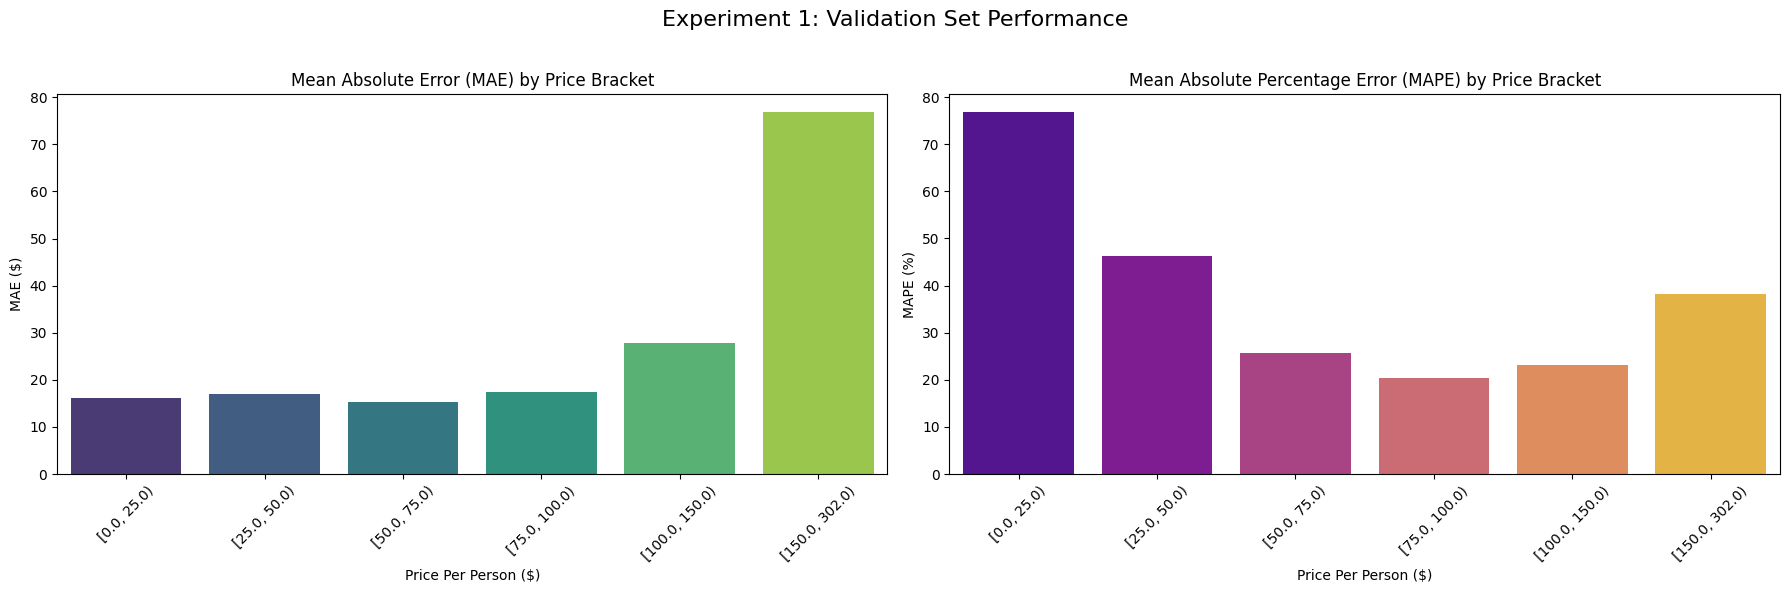

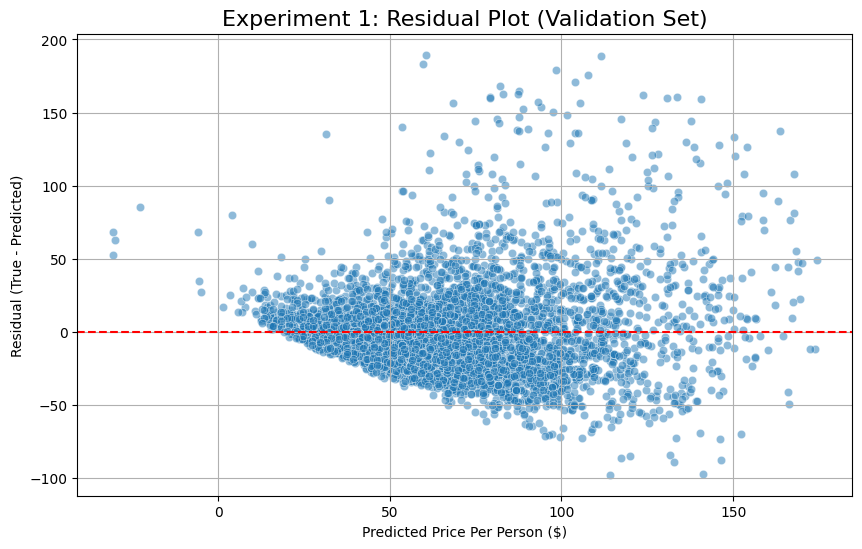

In [18]:
# 4. Visualize the results from the validation set
plot_performance_summary(val_summary, "Experiment 1: Validation Set Performance")
plot_residuals(artifacts['val_df_with_preds'], "Experiment 1: Residual Plot (Validation Set)")